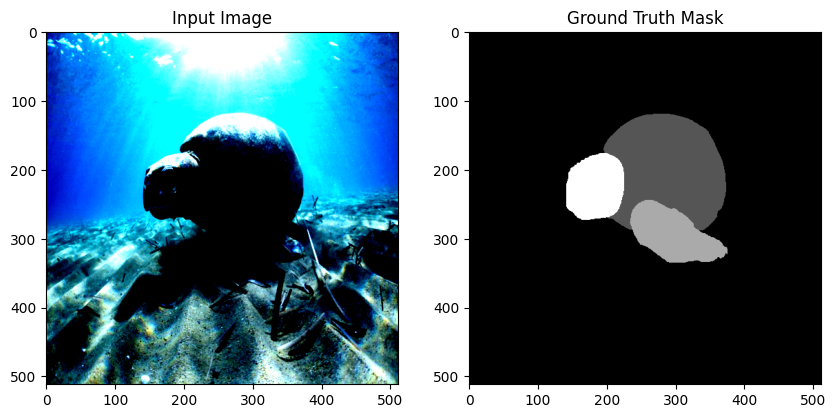

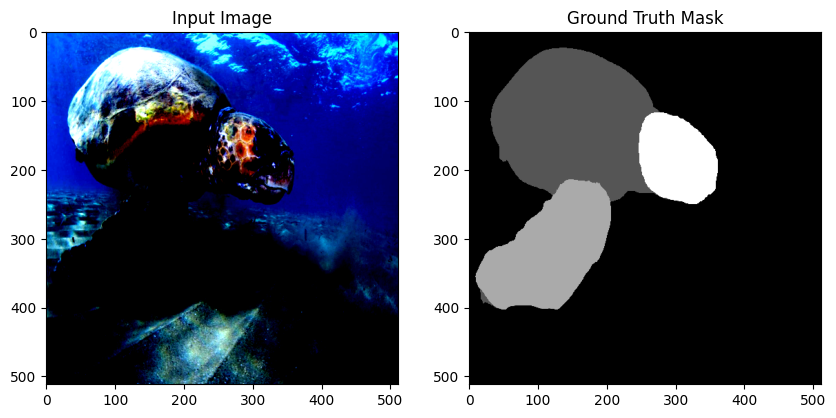

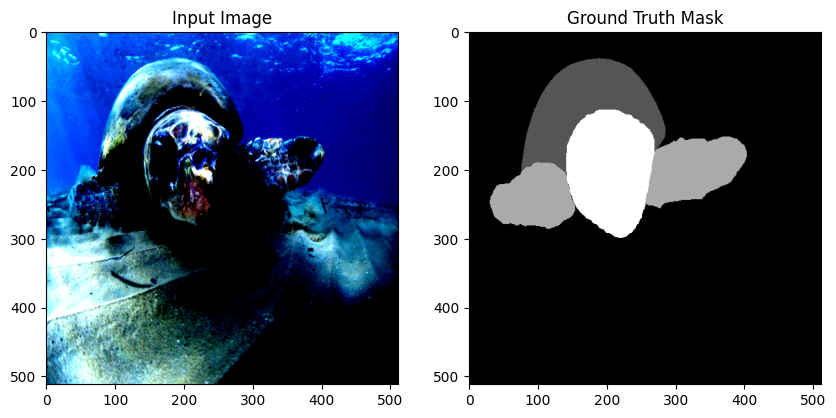

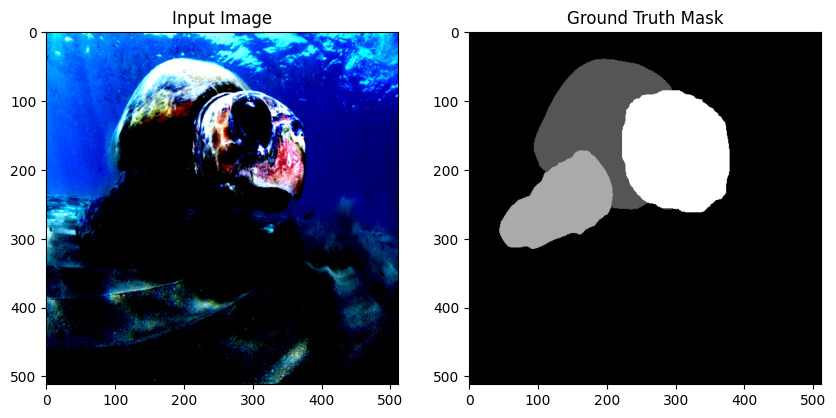

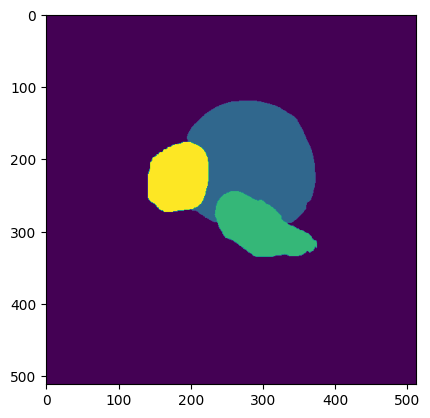

tensor([0., 1., 2., 3.])


In [2]:
import os
import pandas as pd
import json
import numpy as np
from torchvision import transforms
from torch.utils.data import DataLoader, Dataset
from PIL import Image, ImageDraw
import matplotlib.pyplot as plt
from pycocotools import mask as maskUtils

# Read the CSV file, assuming the file path is correct, and read only the columns you need 
# Here is used to obtain the proportion of training, testing and verification data for different identities
df = pd.read_csv('drive/MyDrive/Colab_Notebooks/archive/turtles-data/data/metadata_splits.csv', usecols=['id', 'identity', 'split_open'])

# Divide training, validation, and test data according to the split_open column of the data
train_ids = df[df['split_open'] == 'train']['id'].tolist()
val_ids = df[df['split_open'] == 'valid']['id'].tolist()
test_ids = df[df['split_open'] == 'test']['id'].tolist()

# Load the mask JSON file
with open('drive/MyDrive/Colab_Notebooks/archive/turtles-data/data/annotations.json', 'r') as f:
    mask_annotations = json.load(f)

# 1.Custom data set classes
class TurtleSegmentationDataset(Dataset):
    def __init__(self, img_dir, mask_annotations, ids, transform=None, target_transform=None):
        """
        Initialize the dataset class.
        Parameters:
        - img_dir: Directory of image files
        - mask_annotations: JSON data of masks
        - ids: List of image IDs
        - transform: Transformations for images
        - target_transform: Transformations for masks
        """
        self.img_dir = img_dir
        self.mask_annotations = mask_annotations
        self.ids = ids
        self.transform = transform
        self.target_transform = target_transform
        self.image_size = (512, 512)  # Target image size

    def __len__(self):
        return len(self.ids)

    def __getitem__(self, index):
        image_id = self.ids[index]
        img_info = next(item for item in self.mask_annotations['images'] if item['id'] == image_id)
        img_path = os.path.join(self.img_dir, img_info['file_name'])

        # Load image
        image = Image.open(img_path).convert('RGB')

        # Get mask information and create mask image
        height, width = img_info['height'], img_info['width']
        mask_turtle = np.zeros(self.image_size, dtype=np.uint8)
        mask_flippers = np.zeros(self.image_size, dtype=np.uint8)
        mask_head = np.zeros(self.image_size, dtype=np.uint8)
        annotations = [ann for ann in self.mask_annotations['annotations'] if ann['image_id'] == image_id]
        for ann in annotations:
            category_id = ann['category_id']
            segmentation = ann['segmentation']
            if isinstance(segmentation, dict) and 'counts' in segmentation and isinstance(segmentation['counts'], list):
                # Convert uncompressed RLE to compressed RLE
                rle = maskUtils.frPyObjects([segmentation], height, width)[0]
            else:
                rle = segmentation  # Already in compressed format

            # Decode the segmentation mask (RLE encoded)
            rle_mask = maskUtils.decode(rle)
            rle_mask_resized = np.array(Image.fromarray(rle_mask).resize(self.image_size, Image.NEAREST))
            # Assign each category to the corresponding mask, considering overlap issues
            if category_id == 1:  # Turtle body
                mask_turtle[rle_mask_resized == 1] = 1
            elif category_id == 2:  # Flippers
                mask_flippers[rle_mask_resized == 1] = 2
            elif category_id == 3:  # Head
                mask_head[rle_mask_resized == 1] = 3

        # Merge all masks into the final mask, ensuring overlap parts are handled by priority
        mask = np.maximum(np.maximum(mask_turtle, mask_flippers), mask_head)
        mask = Image.fromarray(mask)

        # Transformations for image and mask
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            mask = self.target_transform(mask)*255

        return image, mask


    def decode_rle(rle, size):
        """
        Decode RLE format
        Parameters:
        - rle: RLE encoded mask data
        - size: Size of the mask (height, width)
        Returns:
        - mask: Decoded mask array
        """
        height, width = size
        flat_mask = np.zeros(height * width, dtype=np.uint8)
        index = 0
        for i in range(0, len(rle), 2):
            if i + 1 >= len(rle):
                break
            start = rle[i]
            length = rle[i + 1]
            flat_mask[index + start:index + start + length] = 1
            index += start + length
        return flat_mask.reshape((height, width))


# 2.Data transformations
image_transform = transforms.Compose([
    transforms.Resize((512, 512)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

mask_transform = transforms.Compose([
    transforms.Resize((512, 512), interpolation=Image.NEAREST),
    transforms.ToTensor()
])

# Create dataset instances for training, validation, and testing
train_dataset = TurtleSegmentationDataset('drive/MyDrive/Colab_Notebooks/archive/turtles-data/data', mask_annotations, train_ids,
                                          transform=image_transform, target_transform=mask_transform)
val_dataset = TurtleSegmentationDataset('drive/MyDrive/Colab_Notebooks/archive/turtles-data/data', mask_annotations, val_ids,
                                        transform=image_transform, target_transform=mask_transform)
test_dataset = TurtleSegmentationDataset('drive/MyDrive/Colab_Notebooks/archive/turtles-data/data', mask_annotations, test_ids,
                                         transform=image_transform, target_transform=mask_transform)

# Use DataLoader to load datasets
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=4, shuffle=False, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=4, shuffle=False, num_workers=4)


# Visualize a batch of data
def visualize_batch(loader):
    """
    Visualize a batch of data, including input images and ground truth masks.
    Parameters:
    - loader: DataLoader object used to load the dataset
    """
    for images, masks in loader:
        batch_size = images.size(0)
        for i in range(batch_size):
            plt.figure(figsize=(10, 5))

            # Display image
            plt.subplot(1, 2, 1)
            plt.title('Input Image')
            plt.imshow(images[i].permute(1, 2, 0).numpy())

            # Display mask
            plt.subplot(1, 2, 2)
            plt.title('Ground Truth Mask')
            plt.imshow(masks[i].squeeze().numpy(), cmap='gray')

            plt.show()
        break


# Visualize a batch of secondary data in a training set
visualize_batch(val_loader)
for img, mask in val_dataset:
    mask = mask.squeeze().numpy()
    plt.imshow(mask)
    plt.show()
    break
for images, masks in val_dataset:
    print(masks.unique())
    break


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# 1.Model Definition and Training Setup
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import numpy as np

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load the pre-trained DeepLabV3 model and modify the final output layer
num_classes = 4
model = torchvision.models.segmentation.deeplabv3_resnet50(pretrained=True)
model.classifier[4] = nn.Conv2d(256, num_classes, kernel_size=(1, 1))
model.to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Function to compute mIoU and IoU
def compute_iou(pred, target, num_classes):
    iou_list = []
    pred = torch.argmax(pred, dim=1)
    for cls in range(num_classes):
        pred_inds = (pred == cls)
        target_inds = (target == cls)
        intersection = (pred_inds & target_inds).sum().item()
        union = (pred_inds | target_inds).sum().item()
        if union == 0:
            iou = float('nan')
        else:
            iou = intersection / union
        iou_list.append(iou)
    avg_iou = np.nanmean(iou_list)
    return iou_list, avg_iou

# 2.Train the Model
num_epochs = 25  # Total number of training epochs

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0

    for images, masks in train_loader:
        # Move data to GPU or CPU
        images = images.to(device)
        masks = masks.to(device)

        
        optimizer.zero_grad()
        outputs = model(images)['out']

        outputs = outputs.permute(0, 2, 3, 1).reshape(-1, num_classes)
        masks = masks.view(-1)
        loss = criterion(outputs, masks.long())
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    # Print average loss for each epoch
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss / len(train_loader):.4f}")

    # Validation set evaluation
    model.eval()
    val_loss = 0.0
    total_iou = 0.0
    iou_per_class = np.zeros(num_classes)
    with torch.no_grad():
        for images, masks in val_loader:
            images = images.to(device)
            masks = masks.to(device)

            # Adjust masks' dimensions to match the requirements of the loss function
            masks = masks.squeeze(1) if masks.ndim == 4 else masks

            outputs = model(images)['out']
            # Reshape outputs and masks to match the requirements of the loss function
            outputs_reshaped = outputs.permute(0, 2, 3, 1).reshape(-1, num_classes)
            masks_reshaped = masks.view(-1)
            # Calculate loss
            loss = criterion(outputs_reshaped, masks_reshaped.long())
            val_loss += loss.item()

            # Calculate mIoU and IoU
            iou_list, avg_iou = compute_iou(outputs, masks, num_classes)
            total_iou += avg_iou
            iou_per_class += np.nan_to_num(iou_list)

    # Print average validation loss, mIoU, and IoU for each class
    avg_val_loss = val_loss / len(val_loader)
    avg_iou = total_iou / len(val_loader)
    iou_per_class /= len(val_loader)
    print(f"Validation Loss: {avg_val_loss:.4f}, mIoU: {avg_iou:.4f}")
    for cls in range(num_classes):
        print(f"IoU for class {cls}: {iou_per_class[cls]:.4f}")

print("Finished！")

# 6. Save the Model
torch.save(model.state_dict(), 'deeplabv3_50_seaturtle_state.pth')


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DeepLabV3_ResNet50_Weights.COCO_WITH_VOC_LABELS_V1`. You can also use `weights=DeepLabV3_ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/deeplabv3_resnet50_coco-cd0a2569.pth" to /root/.cache/torch/hub/checkpoints/deeplabv3_resnet50_coco-cd0a2569.pth
100%|██████████| 161M/161M [00:00<00:00, 184MB/s]


Epoch [1/25], Loss: 0.1449
Validation Loss: 0.1075, mIoU: 0.6894
IoU for class 0: 0.9746
IoU for class 1: 0.7169
IoU for class 2: 0.5478
IoU for class 3: 0.5185
Epoch [2/25], Loss: 0.0755
Validation Loss: 0.0624, mIoU: 0.7890
IoU for class 0: 0.9855
IoU for class 1: 0.7924
IoU for class 2: 0.6917
IoU for class 3: 0.6864
Epoch [3/25], Loss: 0.0598
Validation Loss: 0.0838, mIoU: 0.7472
IoU for class 0: 0.9794
IoU for class 1: 0.7737
IoU for class 2: 0.6259
IoU for class 3: 0.6097
Epoch [4/25], Loss: 0.0514
Validation Loss: 0.0434, mIoU: 0.8371
IoU for class 0: 0.9903
IoU for class 1: 0.8529
IoU for class 2: 0.7419
IoU for class 3: 0.7631
Epoch [5/25], Loss: 0.0435
Validation Loss: 0.0564, mIoU: 0.8002
IoU for class 0: 0.9872
IoU for class 1: 0.8099
IoU for class 2: 0.7127
IoU for class 3: 0.6910
Epoch [6/25], Loss: 0.0386
Validation Loss: 0.0459, mIoU: 0.8229
IoU for class 0: 0.9899
IoU for class 1: 0.8443
IoU for class 2: 0.7191
IoU for class 3: 0.7386
Epoch [7/25], Loss: 0.0337
Validat

In [4]:
# 1.Test the Model
model = torchvision.models.segmentation.deeplabv3_resnet50(pretrained=False)
model.classifier[4] = nn.Conv2d(256, num_classes, kernel_size=(1, 1))
state_dict = torch.load('deeplabv3_50_seaturtle_state.pth')
model.load_state_dict(state_dict, strict=False)
model.to(device)
model.eval()

# Evaluate the test set
test_loss = 0.0
total_iou = 0.0
iou_per_class = np.zeros(num_classes)
with torch.no_grad():
    for images, masks in test_loader:
        images = images.to(device)
        masks = masks.to(device)

        outputs = model(images)['out']
        # Reshape outputs and masks to match the requirements of the loss function
        outputs_reshaped = outputs.permute(0, 2, 3, 1).reshape(-1, num_classes)
        masks_reshaped = masks.view(-1)
        # Calculate loss
        loss = criterion(outputs_reshaped, masks_reshaped.long())
        test_loss += loss.item()
        # Calculate mIoU and IoU
        iou_list, avg_iou = compute_iou(outputs, masks, num_classes)
        total_iou += avg_iou
        iou_per_class += np.nan_to_num(iou_list)

# Print average test loss, mIoU, and IoU for each class
avg_test_loss = test_loss / len(test_loader)
avg_test_iou = total_iou / len(test_loader)
iou_per_class /= len(test_loader)
print(f"Test Loss: {avg_test_loss:.4f}, mIoU: {avg_test_iou:.4f}")
for cls in range(num_classes):
    print(f"IoU for class {cls}: {iou_per_class[cls]:.4f}")


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 162MB/s]
<ipython-input-4-bc150cc706da>:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpic

Test Loss: 0.0288, mIoU: 0.3924
IoU for class 0: 0.8793
IoU for class 1: 0.3140
IoU for class 2: 0.1773
IoU for class 3: 0.1989


Successful Segmentation:


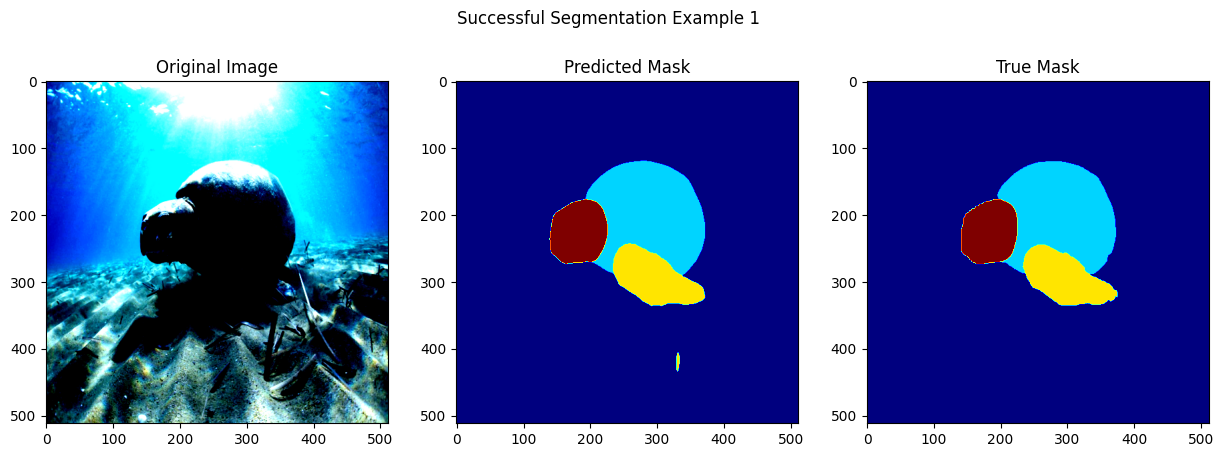

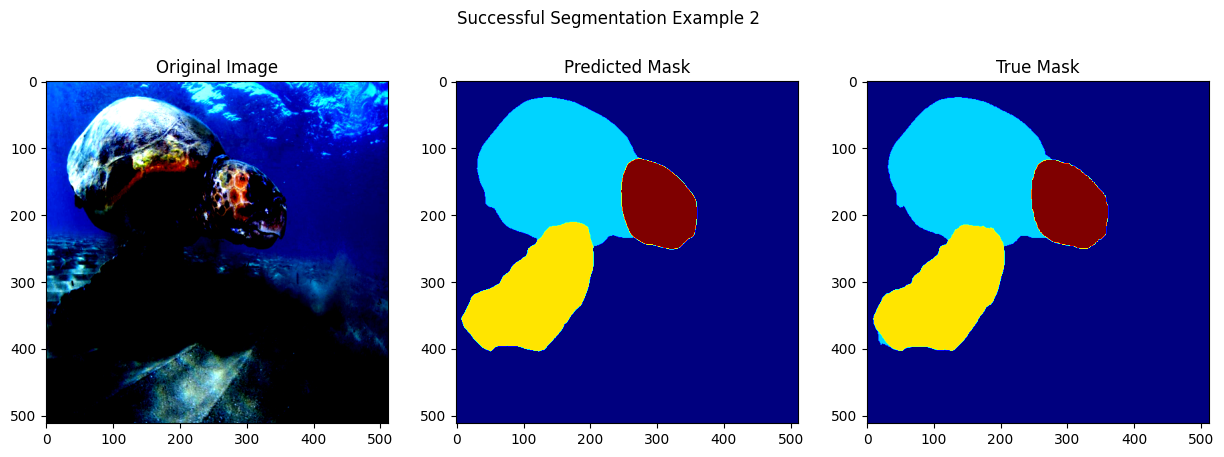

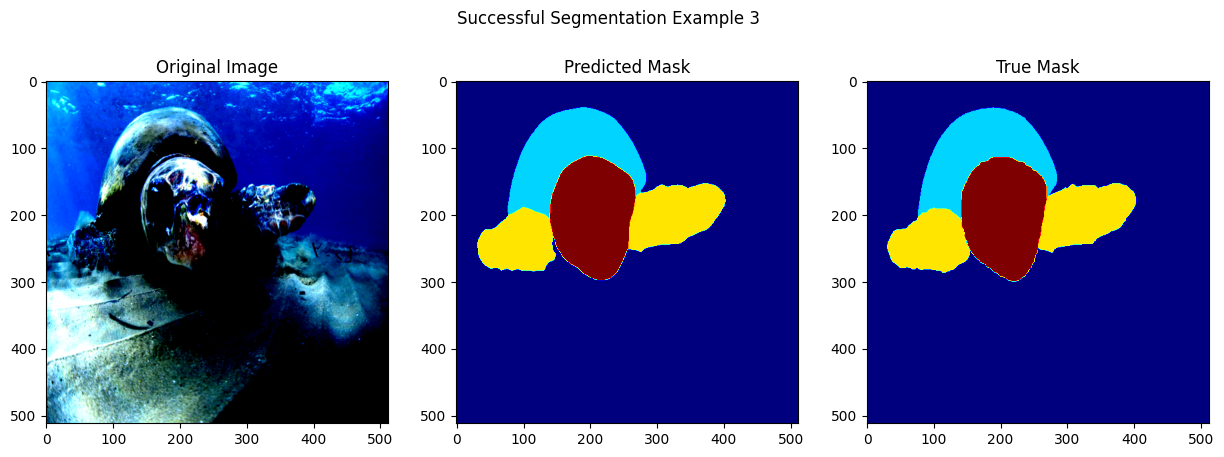

Failed Segmentation:


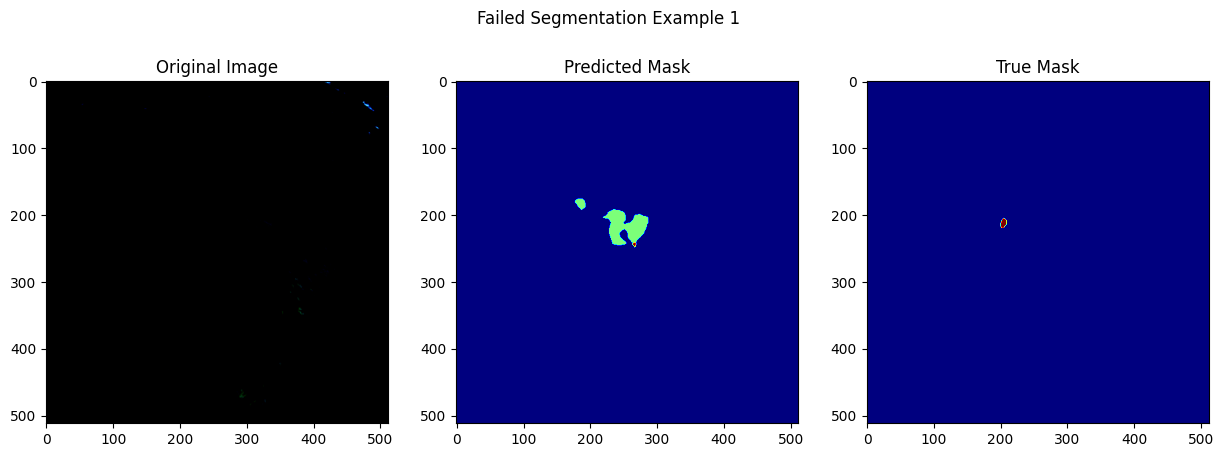

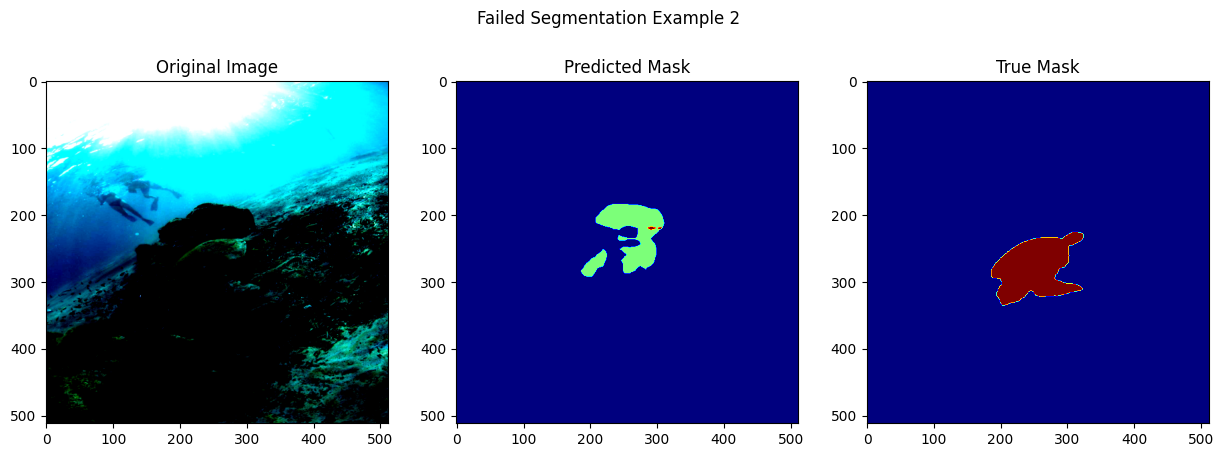

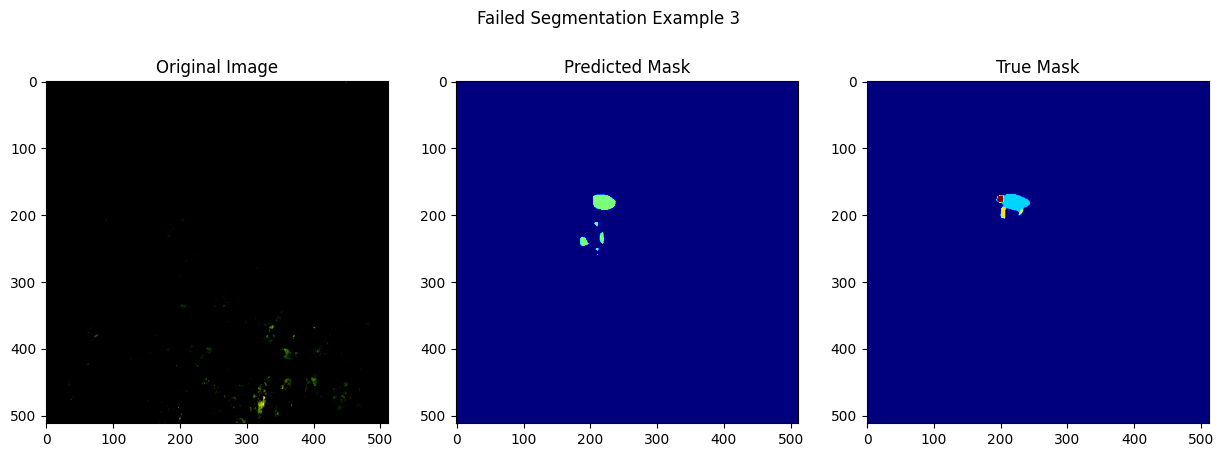

In [6]:
import matplotlib.pyplot as plt

# Define thresholds to determine segmentation success and failure
iou_success_threshold = 0.6
iou_failure_threshold = 0.4

# Lists to store examples of success and failure
success_cases = []
failure_cases = []

# Validation evaluation
model.eval()
with torch.no_grad():
    for images, masks in val_loader:
        images = images.to(device)
        masks = masks.to(device)

        # Get model predictions
        outputs = model(images)['out']
        predicted_masks = torch.argmax(outputs, dim=1)

        # Calculate IoU for each sample
        for i in range(images.size(0)):
            iou_list, avg_iou = compute_iou(outputs[i].unsqueeze(0), masks[i].unsqueeze(0), num_classes)

            # Save examples of success and failure
            if avg_iou >= iou_success_threshold:
                success_cases.append((images[i].cpu(), predicted_masks[i].cpu(), masks[i].cpu()))
            elif avg_iou <= iou_failure_threshold:
                failure_cases.append((images[i].cpu(), predicted_masks[i].cpu(), masks[i].cpu()))

# Visualize representative examples of success and failure
def visualize_examples(examples, title):
    for idx, (image, predicted_mask, true_mask) in enumerate(examples):
        if idx >= 3:
            break

        # Check the shape of the image and handle single or multiple channels
        if image.shape[0] == 1:
            image_np = image.squeeze(0).numpy()
        elif image.shape[0] == 3:
            image_np = image.permute(1, 2, 0).numpy()
        else:
            raise ValueError(f"Unexpected image shape: {image.shape}")

        # Process predicted and true masks, usually single-channel
        predicted_mask_np = predicted_mask.squeeze().numpy()
        true_mask_np = true_mask.squeeze().numpy()

        # Create a subplot to show the original image, predicted mask, and true mask
        fig, axs = plt.subplots(1, 3, figsize=(15, 5))

        # Display the original image
        if image_np.ndim == 2:
            axs[0].imshow(image_np, cmap='gray')
        else:
            axs[0].imshow(image_np)
        axs[0].set_title("Original Image")

        # Display the predicted mask
        axs[1].imshow(predicted_mask_np, cmap='jet')
        axs[1].set_title("Predicted Mask")
        # Display the true mask
        axs[2].imshow(true_mask_np, cmap='jet')
        axs[2].set_title("True Mask")

        fig.suptitle(f"{title} Example {idx + 1}")
        plt.show()

# Visualize success and failure cases
print("Successful Segmentation:")
visualize_examples(success_cases, "Successful Segmentation")

print("Failed Segmentation:")
visualize_examples(failure_cases, "Failed Segmentation")
